# Chapter 6.4 – Architecture Design: Depth vs Width

Explore how depth and width affect network capacity and expressiveness. This notebook demonstrates that deep networks can achieve similar or better performance with fewer parameters by reusing features hierarchically.

## Setup
Import necessary libraries for visualization and computation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure plotting
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
%matplotlib inline

print("✓ Setup complete")

✓ Setup complete


## Exercise: Shallow vs Deep Network Comparison

**Goal**: Compare a shallow network (1 hidden layer with 32 units) against a deep network (5 hidden layers with 2 units each) on the same regression task.

**Key Questions**:
1. Which model has more parameters?
2. Which model learns the function better?
3. Does depth provide an advantage even with fewer parameters?

### Step 1: Generate Data

Create random input `x` and target `y = sin(x)` for regression.

In [2]:
# TODO: Generate training and test data
# Training data
x_train = np.random.rand(200, 1)
y_train = np.square(np.sin(x_train))+np.power(x_train, 3)

# Test data
x_test = np.random.rand(100, 1)
y_test = np.square(np.sin(x_test))+np.power(x_test, 3)

# Convert to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.FloatTensor(y_train)
x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.FloatTensor(y_test)

print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")
print(f"Input range: [{x_train.min():.2f}, {x_train.max():.2f}]")
print(f"Target range: [{y_train.min():.2f}, {y_train.max():.2f}]")

Training samples: 200
Test samples: 100
Input range: [0.01, 0.99]
Target range: [0.00, 1.66]


### Step 2: Define Model Architectures

Create two models:
- **Shallow**: Input → 32 units → Output (total width = 32)
- **Deep**: Input → 2 units → 2 units → 2 units → 2 units → 2 units → Output (5 layers, total width = 10)

In [3]:
# TODO: Define shallow and deep models

# Shallow model: 1 hidden layer with 2^5 = 32 units
shallow_model = nn.Sequential(
    nn.Linear(1, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

# Deep model: 5 hidden layers with 2 units each
deep_model = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
 
    nn.Linear(8, 1)
)

print("✓ Models created")
print(f"\nShallow model architecture:")
print(shallow_model)
print(f"\nDeep model architecture:")
print(deep_model)

✓ Models created

Shallow model architecture:
Sequential(
  (0): Linear(in_features=1, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=1, bias=True)
)

Deep model architecture:
Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
)


### Step 3: Count Parameters

Calculate total number of trainable parameters in each model.

Parameter Counts:
--------------------------------------------------
Shallow model (1 layer × 32 units): 385 parameters
Deep model (5 layers × 2 units):    177 parameters
--------------------------------------------------
Ratio (shallow/deep): 2.18x


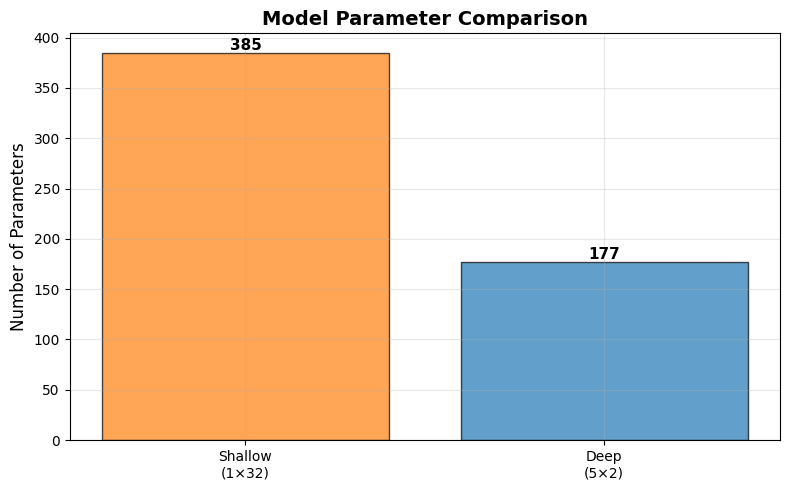

In [4]:
# TODO: Count parameters for each model

def count_parameters(model):
    """Count total trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

shallow_params = count_parameters(shallow_model)
deep_params = count_parameters(deep_model)

print("Parameter Counts:")
print("-" * 50)
print(f"Shallow model (1 layer × 32 units): {shallow_params:,} parameters")
print(f"Deep model (5 layers × 2 units):    {deep_params:,} parameters")
print("-" * 50)
print(f"Ratio (shallow/deep): {shallow_params/deep_params:.2f}x")

# Visualize parameter counts
fig, ax = plt.subplots(figsize=(8, 5))
models = ['Shallow\n(1×32)', 'Deep\n(5×2)']
params = [shallow_params, deep_params]
colors = ['#ff7f0e', '#1f77b4']

bars = ax.bar(models, params, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Parameters', fontsize=12)
ax.set_title('Model Parameter Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, param in zip(bars, params):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{param:,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### Step 4: Train Both Models

Train shallow and deep models on the same data and track their performance.

In [5]:
# TODO: Train both models and compare learning curves

# Training configuration
n_epochs = 500
learning_rate = 0.01
loss_fn = nn.MSELoss()

# Track training history
history = {
    'Shallow': {'train_loss': [], 'test_loss': []},
    'Deep': {'train_loss': [], 'test_loss': []}
}

models = {
    'Shallow': shallow_model,
    'Deep': deep_model
}

# Train each model
for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        y_pred = model(x_train_tensor)
        loss = loss_fn(y_pred, y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        history[name]['train_loss'].append(loss.item())
        
        # Evaluation on test set
        model.eval()
        with torch.no_grad():
            y_test_pred = model(x_test_tensor)
            test_loss = loss_fn(y_test_pred, y_test_tensor).item()
            history[name]['test_loss'].append(test_loss)
    
    print(f"✓ {name} model trained")

print("\n✓ Training complete")

✓ Shallow model trained
✓ Deep model trained

✓ Training complete


### Step 5: Compare Model Performance

Plot learning curves to see which architecture learns better.

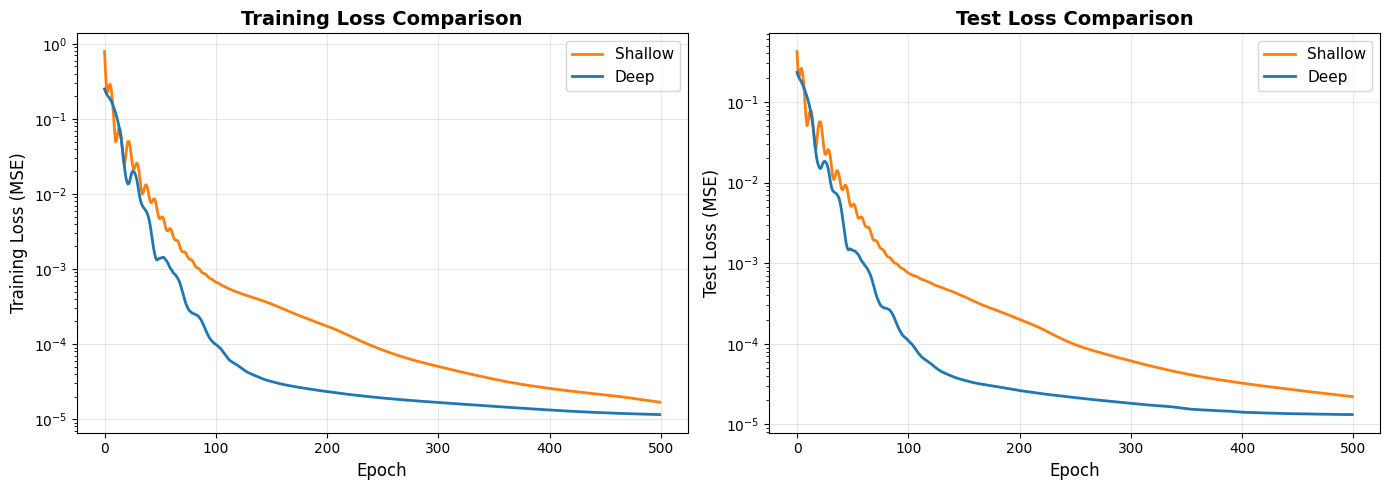


Final Performance (after 500 epochs):
----------------------------------------------------------------------
Model           Parameters      Train Loss      Test Loss      
----------------------------------------------------------------------
Shallow         385             0.000017        0.000022       
Deep            177             0.000012        0.000013       

💡 Key Observations:
   - Which model has more parameters?
   - Which model achieves lower test loss?
   - Does the deep model demonstrate parameter efficiency?


In [6]:
# TODO: Plot learning curves for both models

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {'Shallow': '#ff7f0e', 'Deep': '#1f77b4'}

# Plot training loss
for name, data in history.items():
    axes[0].plot(data['train_loss'], label=name, linewidth=2, color=colors[name])

axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss (MSE)', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Plot test loss
for name, data in history.items():
    axes[1].plot(data['test_loss'], label=name, linewidth=2, color=colors[name])

axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Test Loss (MSE)', fontsize=12)
axes[1].set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Performance (after {} epochs):".format(n_epochs))
print("-" * 70)
print(f"{'Model':<15} {'Parameters':<15} {'Train Loss':<15} {'Test Loss':<15}")
print("-" * 70)
for name in models.keys():
    params = count_parameters(models[name])
    train_loss = history[name]['train_loss'][-1]
    test_loss = history[name]['test_loss'][-1]
    print(f"{name:<15} {params:<15,} {train_loss:<15.6f} {test_loss:<15.6f}")

print("\n💡 Key Observations:")
print("   - Which model has more parameters?")
print("   - Which model achieves lower test loss?")
print("   - Does the deep model demonstrate parameter efficiency?")